In [1]:
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pandas as pd
# Plotting tools
import pyLDAvis.gensim  # don't skip this
# spacy for lemmatization
import spacy
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
%matplotlib inline

from bs4 import BeautifulSoup

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vantuan5644/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('../../ground_truths/ground_truth.csv')
data.head()
stage_level = data[['text', 'stage_level']].groupby('stage_level').agg({'text': lambda text: ' '.join(text),
                                                                        })
data = stage_level.reset_index(level=0)
data

,stage_level,text
0,0.0,Because stage 0 NSCLC is limited to the lining...
1,1.0,"If you have stage I NSCLC, surgery may be the ..."
2,2.0,People who have stage II NSCLC and are healthy...
3,3.0,Treatment for stage IIIA NSCLC may include som...
4,4.0,Stage IV NSCLC is widespread when it is diagno...


In [28]:
doc = list(data['text'].values)
print(doc[0])

Because stage 0 NSCLC is limited to the lining layer of airways and has not invaded deeper into the lung tissue or other areas, it is usually curable by surgery alone. No chemotherapy or radiation therapy is needed. If you are healthy enough for surgery, you can usually be treated by segmentectomy or wedge resection (removal of part of the lobe of the lung). Cancers in some locations (such as where the windpipe divides into the left and right main bronchi) may be treated with a sleeve resection, but in some cases they may be hard to remove completely without removing a lobe (lobectomy) or even an entire lung (pneumonectomy). For some stage 0 cancers, treatments such as photodynamic therapy (PDT), laser therapy, or brachytherapy (internal radiation) may be alternatives to surgery. If your cancer is truly stage 0, these treatments should cure you.


In [4]:
# Remove punctuations, tokenizing
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=False)

In [5]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text, remove_short_words=False, remove_xml_tag=False):
    newString = text.lower()
    if remove_xml_tag:
        newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub('\n+', ' ', newString)
    newString = re.sub("[^a-zA-Z0-9]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    if remove_short_words:
        long_words=[]
        for i in tokens:
            if len(i) >= 3:                  # removing short word
                long_words.append(i)
        return long_words
    else:
        return tokens

In [6]:
# data_words = list(sent_to_words(doc))
data_words = [text_cleaner(d) for d in doc]
pprint(data_words[0][:10])

['stage',
 '0',
 'nsclc',
 'limited',
 'lining',
 'layer',
 'airways',
 'invaded',
 'deeper',
 'lung']


In [7]:
# Creating Bigram and Trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[1]]])


In [8]:
nlp = spacy.load('en', disable=['parser', 'ner'])
from spacy.lang.en.stop_words import STOP_WORDS


In [9]:
# Remove stopwords, make biagrams and lemmatize

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['stage', 'limited', 'line', 'layer', 'airway', 'invade', 'deep', 'lung', 'tissue', 'area', 'usually', 'curable', 'surgery', 'alone', 'chemotherapy', 'radiation', 'therapy', 'need', 'healthy', 'enough', 'surgery', 'usually', 'treat', 'resection', 'cancer', 'location', 'may', 'treat', 'resection', 'case', 'may', 'hard', 'remove', 'completely', 'remove', 'lobe', 'even', 'entire', 'lung', 'stage', 'cancer', 'treatment', 'photodynamic', 'therapy', 'laser', 'therapy', 'may', 'alternatives', 'surgery', 'cancer', 'truly', 'stage', 'treatment', 'cure']


In [11]:
# Create the Dictionary and Corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(1, 1), (2, 1), (4, 1), (6, 1), (7, 1), (8, 1), (9, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (17, 1), (18, 1), (19, 1), (21, 1), (23, 2), (24, 3), (26, 1), (27, 1), (28, 1), (29, 2), (30, 3), (31, 3), (32, 3), (33, 1), (36, 1), (37, 2), (77, 1)]]


In [12]:
# Corpus format: (word_id: freq)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('alone', 1),
  ('alternatives', 1),
  ('cancer', 1),
  ('chemotherapy', 1),
  ('completely', 1),
  ('curable', 1),
  ('cure', 1),
  ('enough', 1),
  ('entire', 1),
  ('even', 1),
  ('hard', 1),
  ('healthy', 1),
  ('laser', 1),
  ('layer', 1),
  ('limited', 1),
  ('lobe', 1),
  ('lung', 2),
  ('may', 3),
  ('photodynamic', 1),
  ('radiation', 1),
  ('remove', 1),
  ('resection', 2),
  ('stage', 3),
  ('surgery', 3),
  ('therapy', 3),
  ('tissue', 1),
  ('truly', 1),
  ('usually', 2),
  ('nsclc', 1)]]

In [13]:
# Choose the optimal number of topics
# By choosing a 'k' that gives the highest coherence value

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


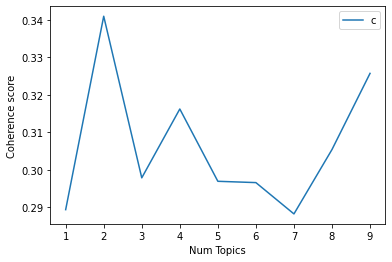

In [19]:
limit=10; start=1; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=start, limit=limit, step=step)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [21]:
# Select the model with the best coherence score
def select_model(model_list, num_topics_desired: int, start, step):
    model_idx = (num_topics_desired - start) / step
    return model_list[int(model_idx)]

model = select_model(model_list,
                     num_topics_desired=2,
                     start=start,
                     step=step)

In [22]:
# Show the topics
model_topics = model.show_topics(formatted=False)
pprint(model.print_topics(num_words=10))

[(0,
  '0.034*"cancer" + 0.029*"surgery" + 0.027*"may" + 0.019*"radiation" + '
  '0.019*"stage" + 0.017*"therapy" + 0.016*"treatment" + 0.014*"lung" + '
  '0.011*"chemo" + 0.010*"nsclc"'),
 (1,
  '0.041*"treatment" + 0.037*"may" + 0.033*"surgery" + 0.033*"cancer" + '
  '0.028*"therapy" + 0.027*"radiation" + 0.024*"chemo" + 0.023*"people" + '
  '0.018*"lung" + 0.018*"nsclc"')]


In [23]:
# Find the dominant topic in each paragraph

def format_topics_sentences(lda_model, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Sort by word frequency
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [24]:
df_topic_sents_keywords = format_topics_sentences(lda_model=model, corpus=corpus, texts=doc)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9603,"treatment, may, surgery, cancer, therapy, radi...",Because stage 0 NSCLC is limited to the lining...
1,1,1.0,0.7913,"treatment, may, surgery, cancer, therapy, radi...","If you have stage I NSCLC, surgery may be the ..."
2,2,0.0,0.7204,"cancer, surgery, may, radiation, stage, therap...",People who have stage II NSCLC and are healthy...
3,3,1.0,0.9953,"treatment, may, surgery, cancer, therapy, radi...",Treatment for stage IIIA NSCLC may include som...
4,4,1.0,0.9978,"treatment, may, surgery, cancer, therapy, radi...",Stage IV NSCLC is widespread when it is diagno...


In [25]:
# Find the most representative document for each topic

def top_k_docs_for_each_topic(k):
    topic_representatives = pd.DataFrame()
    for i, group in df_dominant_topic.groupby('Dominant_Topic'):
        topic_representatives = pd.concat([topic_representatives,
                                                 group.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(k)],
                                                axis=0)
    topic_representatives.reset_index(drop=True, inplace=True)

    # Format
    # topic_representatives.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    return topic_representatives


# Show
top_k_docs_for_each_topic(1).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2,0.0,0.7204,"cancer, surgery, may, radiation, stage, therap...",People who have stage II NSCLC and are healthy...
1,4,1.0,0.9978,"treatment, may, surgery, cancer, therapy, radi...",Stage IV NSCLC is widespread when it is diagno...


In [26]:
# Topic volume distribution
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = top_k_docs_for_each_topic(1)[['Dominant_Topic', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"cancer, surgery, may, radiation, stage, therap...",1,0.2
1.0,1.0,"treatment, may, surgery, cancer, therapy, radi...",4,0.8


In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis




PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.017202  0.0       1        1  87.398132
0     -0.017202  0.0       2        1  12.601858, topic_info=         Term       Freq      Total Category  logprob  loglift
4      cancer  21.000000  21.000000  Default  30.0000  30.0000
31    surgery  20.000000  20.000000  Default  29.0000  29.0000
24        may  22.000000  22.000000  Default  28.0000  28.0000
30      stage  10.000000  10.000000  Default  27.0000  27.0000
27  radiation  16.000000  16.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
84     people   0.816139  13.705923   Topic2  -4.6042  -0.7497
62     health   0.668485   7.758364   Topic2  -4.8038  -0.3802
68     likely   0.590343   5.233472   Topic2  -4.9281  -0.1108
41       also   0.569540   6.150727   Topic2  -4.9639  -0.3082
13       even   0.492700   4.507294   Topic2  -5.1089  -0.1422

[151 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
40        1  0.528650  adjuvant
169       1  0.961693       alk
41        1  0.975494      also
41        2  0.162582      also
43        1  0.746317    behind
...     ...       ...       ...
106       2  0.147127     tumor
229       1  0.916851      used
37        1  0.863483   usually
37        2  0.172697   usually
132       1  0.809865     would

[103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])